<a href="https://colab.research.google.com/github/ljishen/ycsb-rocksdb-data/blob/master/notebooks/model_verify_throughput_hp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ 8.91469189e-05  1.74961152e-04 -3.02134237e-01]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

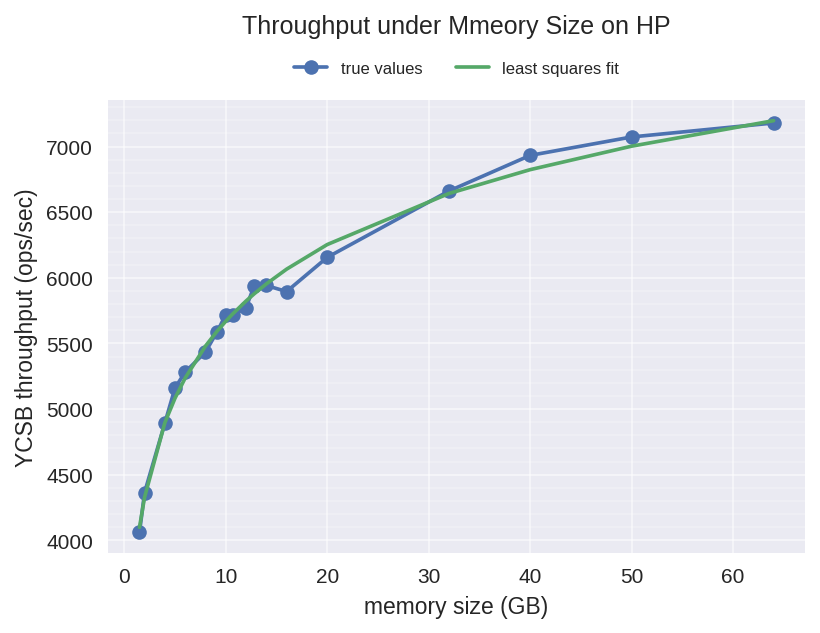

In [2]:
%matplotlib inline

from IPython.display import display, Math
from google.colab.output._publish import javascript
javascript(url="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default")

from matplotlib.ticker import AutoMinorLocator
from scipy.optimize import leastsq

import numpy as np
import matplotlib.pyplot as plt
import sys

mem_sizes = [1.5, 2, 4, 5, 6, 8, 9.14, 10, 10.67, 12, 12.8, 14, 16, 20, 32, 40, 50, 64]
throughputs = [4060.1,
               4364.61,
               4893.92,
               5160.71,
               5282.23,
               5434.52,
               5588.028571,
               5717.71,
               5714.083333,
               5771.57,
               5938.18,
               5941.491862,
               5895.5,
               6155.57,
               6661.3,
               6932.42,
               7072.86,
               7179.4]

# https://en.wikipedia.org/wiki/Power_law_of_cache_misses
# miss_ratio = M0 * C^(-a)
# hit_ratio = 1 - M
# avg_latency = hit_ratio * hit_time + miss_ratio * miss_time
#             = (1 - (M0 * C^(-a))) * hit_time + (M0 * C^(-a)) * (hit_time + disk_access_time)
#             = hit_time + (M0 * C^(-a)) * disk_access_time
# throughput = 1 / avg_latency
# throughput = 1 / (hit_time + (M0 * C^(-a)) * disk_access_time)

# throughput = 1 / (k + h * x^(-a))
# 1 / throughput = k + h * x^(-a)

def fitfunc(p, x):
    return p[0] + p[1] * (x ** p[2])
def errfunc(p, x, y):
    return y - fitfunc(p, x)

xdata = mem_sizes
ydata = np.reciprocal(throughputs)

sol, cov_x, infodict, mesg, ier = leastsq(errfunc, [1, 1, -1], args=(xdata, ydata), full_output=True)
print(sol)

# https://stackoverflow.com/questions/7588371/scipy-leastsq-goodness-of-fit-estimator
# How to interpret R-squared? (value range 0-1, the bigger the better)
#   http://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit
ss_err = np.sum(infodict['fvec'] ** 2)
ss_tot = np.sum((ydata - np.mean(ydata)) ** 2)
rsquared = 1 - (ss_err / ss_tot)

display(Math(r'R^{2}=%f' % rsquared))
display(Math(r'throughput(c) = \frac{1}{ %f + %f * c^{-%f} }' % (sol[0], sol[1], -1 * sol[2])))

fig, ax = plt.subplots()
fig.set_dpi(150)
ax.grid(which='major', alpha=0.5)
ax.yaxis.grid(which='minor', alpha=0.2)

plt.errorbar(mem_sizes, throughputs, fmt='-o', label='true values')
fit_ys = [1 / (fitfunc(sol, m)) for m in mem_sizes]
plt.errorbar(mem_sizes, fit_ys, label='least squares fit')

ax.set_ylabel('YCSB throughput (ops/sec)')
ax.set_xlabel('memory size (GB)')
ax.set_title('Throughput under Mmeory Size on HP', y=1.12)

ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.legend(loc=8,
           bbox_to_anchor=(0.5, 1.02),
           ncol=2,
           frameon=False,
           prop={'size': 8})

plt.show()